# ORF recognition by Convolutional/Recurrent

So far CNN+LSTM 64 overfits the 128 base RNA problem.
That was using 32K samples/class. Here, try more samples. 

Also, build the model without specifying INPUT_SIZE.



In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-28 16:24:21 UTC'

In [2]:
#Input
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=128            # how long is each sequence
CDS_LEN=64            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs

#Model
FILTERS = 16   # how many different patterns the model looks for
CELLS = 128 #Used in LSTM layer(s)
NEURONS = 128 #Used in Dense layer(s)
DROP_RATE = 0.2
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases

#Training
EPOCHS=25  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 42 trials to reach 10 per class.
It took 129586 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 128.0
Average ORF length: 81.21272727272728
NC seqs
Average RNA length: 128.0
Average ORF length: 28.87709090909091


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    #dnn.build(input_shape=INPUT_SHAPE)   
    dnn.build()   
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (128, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 16)           208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 16)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 128)           74240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)        

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/25
1334/1334 [==============================] - 37s 13ms/step - loss: 0.7000 - accuracy: 0.5270 - val_loss: 0.6633 - val_accuracy: 0.5989


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/25
1334/1334 [==============================] - 16s 12ms/step - loss: 0.6678 - accuracy: 0.5912 - val_loss: 0.6332 - val_accuracy: 0.6391


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.6354 - accuracy: 0.6332 - val_loss: 0.6007 - val_accuracy: 0.6731


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/25
1334/1334 [==============================] - 16s 12ms/step - loss: 0.6069 - accuracy: 0.6578 - val_loss: 0.6369 - val_accuracy: 0.6302
Epoch 5/25
1334/1334 [==============================] - 17s 12ms/step - loss: 0.6470 - accuracy: 0.6185 - val_loss: 0.6155 - val_accuracy: 0.6623
Epoch 6/25
1334/1334 [==============================] - 17s 12ms/step - loss: 0.6021 - accuracy: 0.6713 - val_loss: 0.5805 - val_accuracy: 0.6851


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/25
1334/1334 [==============================] - 16s 12ms/step - loss: 0.5786 - accuracy: 0.6859 - val_loss: 0.5700 - val_accuracy: 0.6927


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/25
1334/1334 [==============================] - 17s 12ms/step - loss: 0.5633 - accuracy: 0.6977 - val_loss: 0.5619 - val_accuracy: 0.6968


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/25
1334/1334 [==============================] - 17s 12ms/step - loss: 0.5557 - accuracy: 0.7016 - val_loss: 0.5619 - val_accuracy: 0.6967
Epoch 10/25
1334/1334 [==============================] - 16s 12ms/step - loss: 0.5477 - accuracy: 0.7115 - val_loss: 0.5594 - val_accuracy: 0.7009


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.5431 - accuracy: 0.7115 - val_loss: 0.5592 - val_accuracy: 0.6932
Epoch 12/25
1334/1334 [==============================] - 17s 12ms/step - loss: 0.5283 - accuracy: 0.7221 - val_loss: 0.4616 - val_accuracy: 0.7889


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 13/25
1334/1334 [==============================] - 16s 12ms/step - loss: 0.3752 - accuracy: 0.8367 - val_loss: 0.5812 - val_accuracy: 0.6976
Epoch 14/25
1334/1334 [==============================] - 17s 12ms/step - loss: 0.5482 - accuracy: 0.7177 - val_loss: 0.6143 - val_accuracy: 0.6620
Epoch 15/25
1334/1334 [==============================] - 16s 12ms/step - loss: 0.5784 - accuracy: 0.6917 - val_loss: 0.6576 - val_accuracy: 0.6238
Epoch 16/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.6103 - accuracy: 0.6602 - val_loss: 0.4469 - val_accuracy: 0.7802
Epoch 17/25
1334/1334 [==============================] - 17s 12ms/step - loss: 0.4528 - accuracy: 0.7758 - val_loss: 0.4109 - val_accuracy: 0.8080


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.4043 - accuracy: 0.8103 - val_loss: 0.2837 - val_accuracy: 0.8690


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 19/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.2932 - accuracy: 0.8625 - val_loss: 0.2508 - val_accuracy: 0.8842


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.2423 - accuracy: 0.8841 - val_loss: 0.2538 - val_accuracy: 0.8934


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.2034 - accuracy: 0.9072 - val_loss: 0.1831 - val_accuracy: 0.9198


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 22/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.1518 - accuracy: 0.9283 - val_loss: 0.1625 - val_accuracy: 0.9299


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.1520 - accuracy: 0.9292 - val_loss: 0.1664 - val_accuracy: 0.9282
Epoch 24/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.1572 - accuracy: 0.9278 - val_loss: 0.1308 - val_accuracy: 0.9389


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.2079 - accuracy: 0.8981 - val_loss: 0.1461 - val_accuracy: 0.9349
Fold 1, 25 epochs, 556 sec


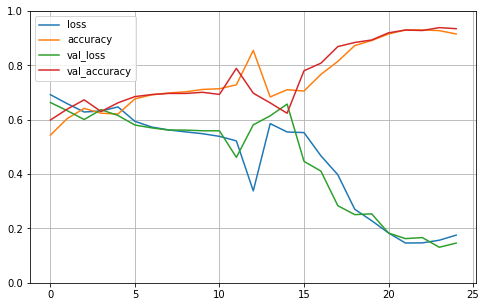

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/25
1334/1334 [==============================] - 22s 14ms/step - loss: 0.6974 - accuracy: 0.5334 - val_loss: 0.6744 - val_accuracy: 0.5828
Epoch 2/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.6751 - accuracy: 0.5766 - val_loss: 0.6455 - val_accuracy: 0.6294
Epoch 3/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.6426 - accuracy: 0.6272 - val_loss: 0.6253 - val_accuracy: 0.6525
Epoch 4/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.6174 - accuracy: 0.6554 - val_loss: 0.5967 - val_accuracy: 0.6767
Epoch 5/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.5934 - accuracy: 0.6738 - val_loss: 0.6377 - val_accuracy: 0.6352
Epoch 6/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.5866 - accuracy: 0.6780 - val_loss: 0.6526 - val_accuracy: 0.6191
Epoch 7/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.614

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.1170 - accuracy: 0.9433 - val_loss: 0.1307 - val_accuracy: 0.9357
Epoch 19/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.1274 - accuracy: 0.9399 - val_loss: 0.1176 - val_accuracy: 0.9417


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/25
1334/1334 [==============================] - 18s 13ms/step - loss: 0.1023 - accuracy: 0.9504 - val_loss: 0.1167 - val_accuracy: 0.9450


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.1106 - accuracy: 0.9504 - val_loss: 0.1166 - val_accuracy: 0.9423
Epoch 22/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.1094 - accuracy: 0.9468 - val_loss: 0.1193 - val_accuracy: 0.9444
Epoch 23/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.2828 - accuracy: 0.8646 - val_loss: 0.1895 - val_accuracy: 0.9207
Epoch 24/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.1339 - accuracy: 0.9435 - val_loss: 0.1315 - val_accuracy: 0.9412
Epoch 25/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.2001 - accuracy: 0.9048 - val_loss: 0.4643 - val_accuracy: 0.7614
Fold 2, 25 epochs, 456 sec


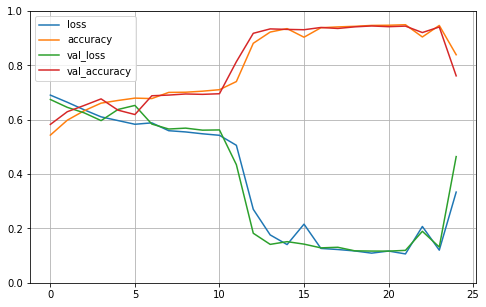

MODEL
make_DNN
input shape: (128, 4)
FIT
Epoch 1/25
1334/1334 [==============================] - 21s 13ms/step - loss: 0.6986 - accuracy: 0.5298 - val_loss: 0.6692 - val_accuracy: 0.5920
Epoch 2/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.6513 - accuracy: 0.6177 - val_loss: 0.6332 - val_accuracy: 0.6354
Epoch 3/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.6328 - accuracy: 0.6352 - val_loss: 0.6250 - val_accuracy: 0.6474
Epoch 4/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.6277 - accuracy: 0.6429 - val_loss: 0.6138 - val_accuracy: 0.6596
Epoch 5/25
1334/1334 [==============================] - 18s 13ms/step - loss: 0.6123 - accuracy: 0.6574 - val_loss: 0.5796 - val_accuracy: 0.6894
Epoch 6/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.5716 - accuracy: 0.6927 - val_loss: 0.5662 - val_accuracy: 0.6949
Epoch 7/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.550

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/25
1334/1334 [==============================] - 17s 13ms/step - loss: 0.0879 - accuracy: 0.9583 - val_loss: 0.1179 - val_accuracy: 0.9456
Fold 3, 25 epochs, 439 sec


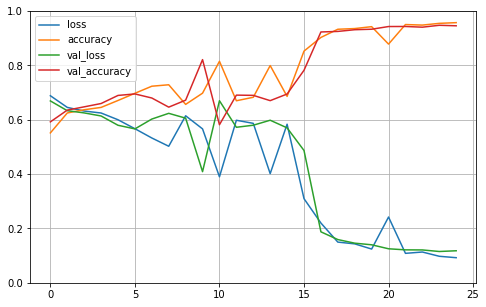

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 96.00%


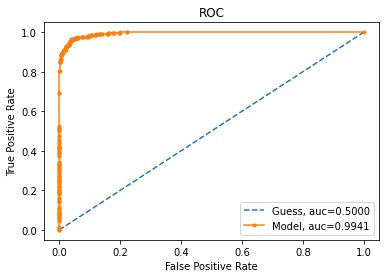

AUC: 99.41%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-28 16:48:57 UTC'